# Init

In [1]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [2]:
from sklearn import preprocessing

In [3]:
from scoring import scoring

In [4]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [5]:
%load_ext autoreload
%autoreload 2

# Load Data

## Blogcatalog

In [11]:
blogcatalog = loadmat('example_graphs/blogcatalog.mat')
blog_labels = blogcatalog['group']
A = blogcatalog['network']
N = A.shape[0]

In [12]:
A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [13]:
N

10312

Utility function for power law distribution:

In [43]:
import powerlaw
def powerlaw_plot(d):
    fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
    fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
    fit.plot_pdf(color= 'b')

    print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

In [9]:
d = [l[0] for l in blog_A.sum(axis=1).tolist()]

alpha=  1.258526391056572   sigma=  0.0025458536330247006


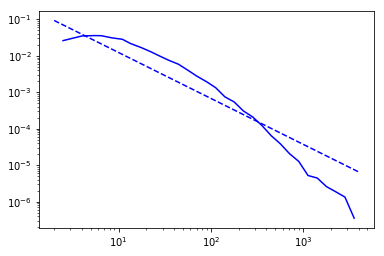

In [44]:
powerlaw_plot(d)

# Powers of Transition Matrix

Compute the transition matrix $M$:

In [14]:
normalizer = spdiags(np.squeeze(1.0 / csc_matrix.sum(A, axis=1) ), 0, N, N)
M = normalizer @ A

Powers of the transition matrix:

In [18]:
%%time
cur, M_pow = M, [spdiags(N, N, 0, 0)]
for i in range(4):
    print (i + 1)
    M_pow.append(cur)
    cur = cur * M

1
2
3
4
CPU times: user 1min 17s, sys: 2.43 s, total: 1min 19s
Wall time: 1min 19s


In [235]:
from scipy.stats import kurtosis, skew

In [238]:
alpha = -0.6
M_pow_4_alpha = M_pow[4] @ spdiags( np.squeeze(np.power(csc_matrix.sum(A, axis=1) / (2 * N), alpha)), 0, N, N)

In [248]:
M_pow_4_samples = M_pow[4].toarray().flatten()

In [249]:
pd.Series(M_pow_4_samples).describe()

count    1.063373e+08
mean     9.697440e-05
std      2.468538e-04
min      0.000000e+00
25%      1.303794e-05
50%      3.360498e-05
75%      8.903702e-05
max      6.783456e-02
dtype: float64

In [250]:
skew(M_pow_4_samples)

10.507376266546338

In [251]:
kurtosis(M_pow_4_samples)

312.4469119935701

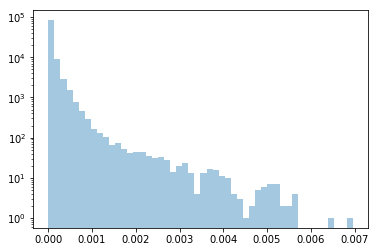

In [221]:
sns.distplot(M_pow_4_samples, hist_kws={'log': True}, kde=False)

In [ ]:
pd.Series(M_pow_4_alpha_samples).describe()

In [ ]:
skew(M_pow_4_alpha_samples)

In [ ]:
kurtosis(M_pow_4_alpha_samples)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


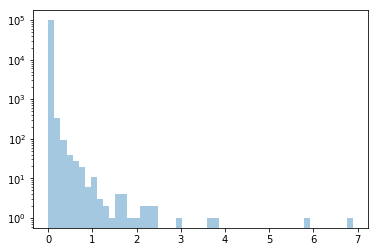

In [212]:
sns.distplot(M_pow_4_alpha_samples, hist_kws={'log': True}, kde=False)

In [247]:
M_pow_4_beta = np.power(M_pow[4].toarray(), 0.5)

In [254]:
M_pow_4_beta_samples = M_pow_4_beta.flatten()

In [256]:
skew(M_pow_4_beta_samples)

3.0439762979505085

In [257]:
kurtosis(M_pow_4_beta_samples)

16.06449391097046

In [181]:
from sklearn.preprocessing import scale

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


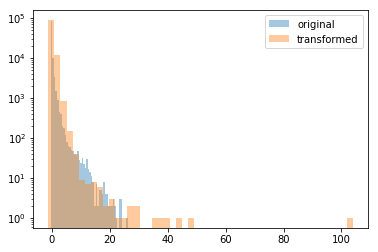

In [182]:
sns.distplot(scale(M_pow_4_samples), hist_kws={'log': True}, kde=False, label='original')
sns.distplot(scale(M_pow_4_alpha_samples), hist_kws={'log': True}, kde=False, label='transformed')
plt.legend()

Distribution of element values:

In [111]:
elements = sorted(np.squeeze(np.array(M_pow[2][4328].todense()) ).tolist(), reverse=True)
sum(elements[:100])

0.2883861431477283

In [112]:
elements = sorted(np.squeeze(np.array(M_pow[3][4328].todense()) ).tolist(), reverse=True)
sum(elements[:100])

0.19829415681531415

In [108]:
M_pow[1].data

array([0.00840336, 0.00840336, 0.00840336, ..., 0.25      , 0.25      ,
       0.25      ])

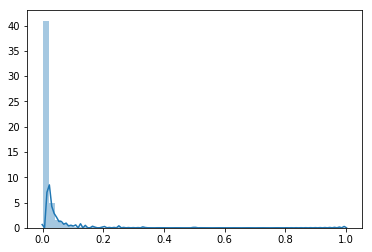

In [55]:
sns.distplot(M_pow[1].data)

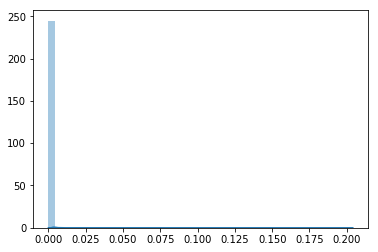

In [56]:
%time sns.distplot(M_pow[2].data)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 18s, sys: 12.6 s, total: 1min 30s
Wall time: 51.2 s


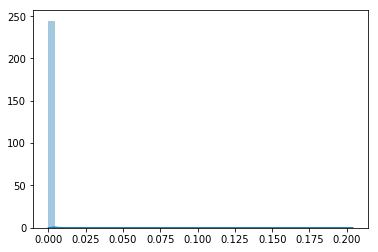

In [113]:
%time sns.distplot(M_pow[3].data)

alpha=  2.412692176554528   sigma=  0.001728503890986654


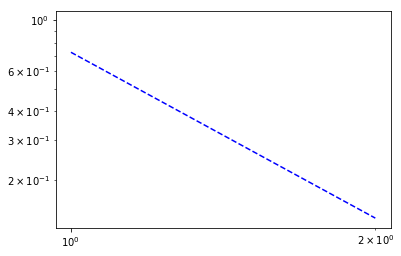

In [45]:
powerlaw_plot(M_pow[1].data)